7043
2493
Churn
0    5174
1    5174
Name: count, dtype: int64
Scores:
    Fold  Accuracy  Precision    Recall        F1  Custom Score
0     1  0.975845   0.981427  0.970048  0.975705     -0.084058
1     2  0.972947   0.973863  0.971981  0.972921     -0.083092
2     3  0.978261   0.983398  0.972947  0.978145     -0.075845
3     4  0.971000   0.977451  0.964217  0.970789     -0.100532
4     5  0.974384   0.977626  0.971014  0.974309     -0.083615

Statistics:
                    Min      Mean       Max
accuracy         0.971  0.974487  0.978261
precision     0.973863  0.978753  0.983398
recall        0.964217  0.970041  0.972947
f1            0.970789  0.974374  0.978145
custom_score -0.100532 -0.085428 -0.075845
Best hyperparameters:
{'C': 1, 'max_iter': 5000, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5174
           1       0.99      0.98      0.98      5174

    accuracy                           0.98

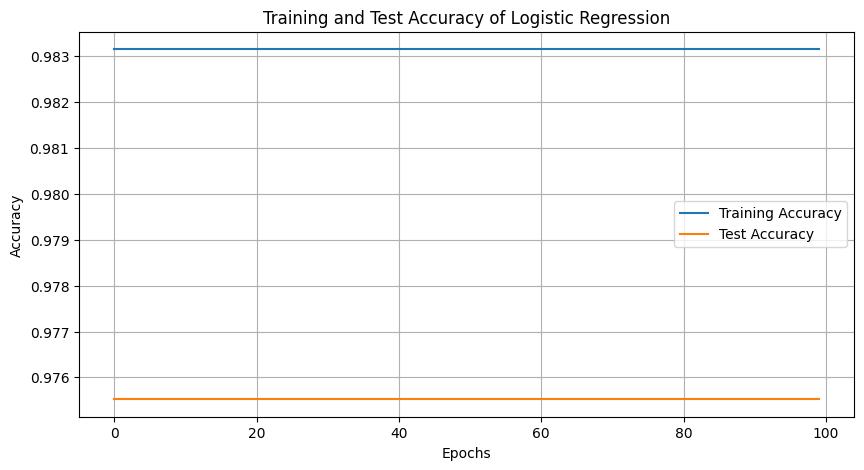

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import os
import joblib

# Read data
df = pd.read_csv('data/churn_data_encoded.csv')
df_test = pd.read_csv('data/churn_data.csv')

print(len(df_test))
print(len(df_test.dropna()))

# Define custom scoring function
def custom_score(y_true, y_pred):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    total = len(y_true)
    score = (fp + 5 * fn) / total
    return score

def print_scores(scores):
    scores_df = pd.DataFrame({
        'Fold': np.arange(1, len(scores['test_accuracy']) + 1),
        'Accuracy': scores['test_accuracy'],
        'Precision': scores['test_precision'],
        'Recall': scores['test_recall'],
        'F1': scores['test_f1'],
        'Custom Score': scores['test_custom_score'],
    })
    print("Scores:\n", scores_df)

    metrics = ['accuracy', 'precision', 'recall', 'f1', 'custom_score']
    statistics = pd.DataFrame(index=metrics, columns=['Min', 'Mean', 'Max'])

    for metric in metrics:
        statistics.loc[metric, 'Min'] = scores['test_' + metric].min()
        statistics.loc[metric, 'Mean'] = scores['test_' + metric].mean()
        statistics.loc[metric, 'Max'] = scores['test_' + metric].max()
    print("\nStatistics:\n", statistics)

def evaluate_classification(X, y, classifier):
    custom_scorer = make_scorer(custom_score, greater_is_better=False)
    cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=42)

    scores = cross_validate(
        classifier,
        X,
        y,
        cv=cv,
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'custom_score': custom_scorer,
        }
    )
    print_scores(scores)
    return scores

# Prepare data
X = df.drop('Churn', axis=1)
y = df['Churn']

# Balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(y_resampled.value_counts())

# Scale features
scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Train Logistic Regression
clf = LogisticRegression(max_iter=2000, solver='lbfgs', random_state=42)
scores = evaluate_classification(X_resampled_scaled, y_resampled, clf)

# Train with best hyperparameters
def apply_grid_search(classifier, param_grid, X, y, cv=5, scoring='accuracy'):
    grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring=scoring)
    grid_search.fit(X, y)
    print("Best hyperparameters:")
    print(grid_search.best_params_)
    return grid_search.best_estimator_

param_grid = {
    'max_iter': [5000, 10000],
    'solver': ['lbfgs', 'liblinear'],
    'C': [0.1, 1, 10]
}

best_model = apply_grid_search(LogisticRegression(random_state=42), param_grid, X_resampled_scaled, y_resampled, cv=5, scoring='accuracy')

# Train final model
best_model.fit(X_resampled_scaled, y_resampled)
y_pred = best_model.predict(X_resampled_scaled)

result = classification_report(y_resampled, y_pred)
print(result)

conf_matrix = confusion_matrix(y_resampled, y_pred)
print(conf_matrix)

conf_matrix_rel = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
print(conf_matrix_rel)

fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
cost = fp + 5 * fn
print("Cost: ", cost)

# Save model
os.makedirs('models', exist_ok=True)
joblib.dump(best_model, 'models/logistic_regression_model.pkl')

# Plotting training vs testing accuracy (for illustration, though not applicable for Logistic Regression)
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.3, random_state=42)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
train_acc = []
test_acc = []
for _ in range(100):  # Dummy loop for illustration
    log_reg.fit(X_train, y_train)

    y_pred_train = log_reg.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_acc.append(train_accuracy)

    y_pred_test = log_reg.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_acc.append(test_accuracy)

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Training and Test Accuracy of Logistic Regression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
